In [1]:
import os
import h5py
import gvar   as gv
import numpy  as np
import pandas as pd
from   matplotlib import pyplot as plt

def RatioFileString(name,ts,h,hss,q,l,p):
    return f'{name}T{ts}{h}_RW_{hss}_rot_rot{q}{l}_p{p}'

def format(v):
    return gv.gvar(
        v.mean(axis=0),
        v.std(axis=0) * np.sqrt(v.shape[0]-1)
    )

def plot(v):
    plt.errorbar(
        np.arange(len(v)),
        gv.mean(v),
        gv.sdev(v),
        fmt='.'
    )

def jkCorr(data, bsize=1):
    if bsize==0:
        return data
    else:
        rData = (data.shape[0]//bsize)
        nData = rData*bsize
        dIn   = data[0:nData,:]

        avg   = dIn.mean(axis=0)

        base  = dIn.sum(axis=0) # avg * nData

        dOut  = dIn * 0.0

        for cf in range(rData):
            pvg = dIn[cf*bsize:(cf+1)*bsize,:].sum(axis=0)
            dOut[cf,:] = (base - pvg)/(nData - bsize)

        return dOut[:rData,:]

In the following cell import `FnalHISQMetadata` module giving the correct path

In [2]:
from b2heavy.FnalHISQMetadata import params # change

ens = 'Coarse-1'
mom = '300'
jk  = 11

mdata = params(ens)
Ta,Tb = mdata['hSinks']

heavy = '_k' + mdata['kBStr']
light = '_k' + mdata['kDStr']
qq    = '_m' + mdata['mlStr']

data = h5py.File(f'/Users/pietro/code/data_analysis/BtoD/Alex/Ensembles/FnalHISQ/a0.12/{mdata["hdf5File2"]}')
data = data['data']

$$
 X_1(\mathbf{p}_\perp,t,T) = \frac{ C_{B_{1S}\rightarrow D^*_a}^{A_j}(\mathbf{p}_\perp,t,T) }{  C_{B_{1S}\rightarrow D^*_a}^{A_j}(\mathbf p_\parallel,t,T)  } \quad/\quad \sqrt{  \frac{ Z_{D_a^*}(\mathbf p_\perp) }{ Z_{D_a^*}(\mathbf p_\parallel) }  }
$$ 

## Reading

in the following cells we read the data from the archive and we build the uncorrected ratio for each smearing and each sink time and we put it in a dictionary `data_read`

------------- tsink = 12 --------- smr = '1S' -------------------
P5_A1_V1_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p300
P5_A2_V2_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p300
P5_A3_V3_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p300
------------- tsink = 13 --------- smr = '1S' -------------------
P5_A1_V1_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p300
P5_A2_V2_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p300
P5_A3_V3_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p300
------------- tsink = 12 --------- smr = 'RW' -------------------
P5_A1_V1_T12_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p300
P5_A2_V2_T12_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p300
P5_A3_V3_T12_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p300
------------- tsink = 13 --------- smr = 'RW' -------------------
P5_A1_V1_T13_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p300
P5_A2_V2_T13_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p300
P5_A3_V3_T13_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p300


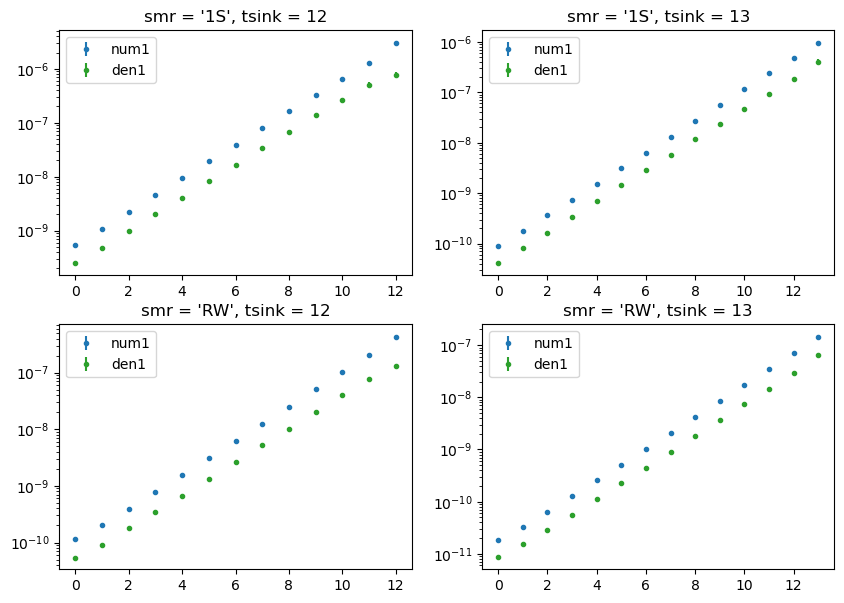

In [29]:
fig,ax = plt.subplots(2,2,figsize=(10,7))

data_read = {}
for i,smr in enumerate(['1S','RW']):
    data_read[smr] = {}
    for j,tsink in enumerate([Ta,Tb]):
        print(f'------------- {tsink = } --------- {smr = } -------------------')

        # Numerator 1
        corr = RatioFileString('P5_A1_V1_',tsink,heavy,smr,qq,light,mom)
        num1 = jkCorr(-data[corr][:,:(tsink+1)], bsize=jk)
        print(corr)

        # Denominator 1
        corr = RatioFileString('P5_A2_V2_',tsink,heavy,smr,qq,light,mom)
        den1 = jkCorr(-data[corr][:,:(tsink+1)], bsize=jk)
        print(corr)

        corr = RatioFileString('P5_A3_V3_',tsink,heavy,smr,qq,light,mom)
        den2 = jkCorr(-data[corr][:,:(tsink+1)], bsize=jk)
        print(corr)

        r = num1 / (den1 + den2)
        data_read[smr][tsink] = r[:,:Ta]

        v = format(num1)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='num1',color='C0')
        v = format(den1)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='den1',color='C2')
        # v = format(den2)
        # ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='den2',color='C3')

        ax[i,j].set_title(f'{smr = }, {tsink = }')
        ax[i,j].set_yscale('log')
        ax[i,j].legend()

-------------- tsink = 12 smr = '1S' --------------
[1.113(13) 1.135(18) 1.128(20) 1.129(25) 1.143(30) 1.152(35) 1.171(41)
 1.184(49) 1.192(56) 1.206(67) 1.205(77) 1.229(93)]
12
-------------- tsink = 13 smr = '1S' --------------
[1.089(17) 1.096(25) 1.104(29) 1.098(35) 1.097(41) 1.089(41) 1.100(44)
 1.117(53) 1.148(59) 1.188(71) 1.201(81) 1.268(98)]
12
-------------- tsink = 12 smr = 'RW' --------------
[1.046(15) 1.069(21) 1.082(21) 1.095(24) 1.111(28) 1.119(31) 1.117(37)
 1.146(42) 1.158(48) 1.168(53) 1.178(60) 1.235(73)]
12
-------------- tsink = 13 smr = 'RW' --------------
[1.058(20) 1.076(30) 1.103(35) 1.136(39) 1.146(45) 1.126(50) 1.150(53)
 1.170(60) 1.190(65) 1.198(73) 1.177(80) 1.200(91)]
12


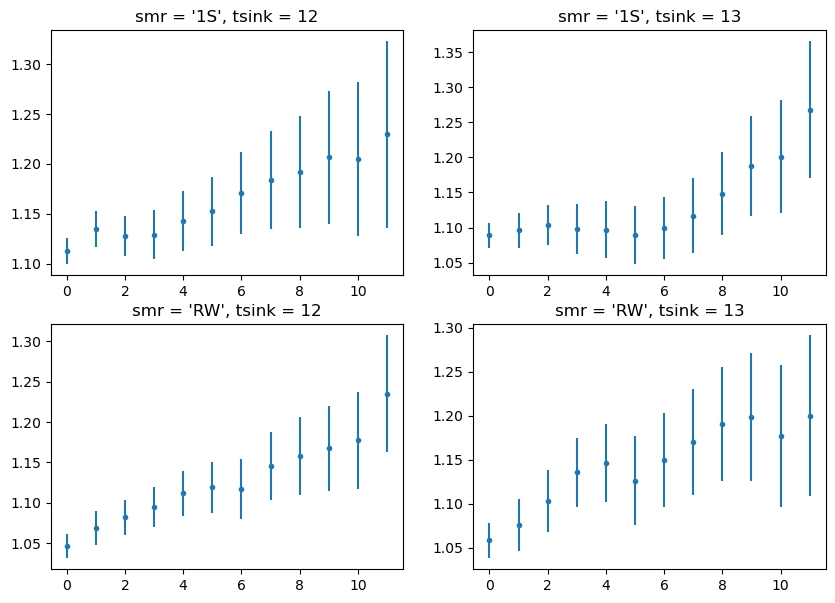

In [30]:
fig,ax = plt.subplots(2,2,figsize=(10,7))
for i,smr in enumerate(data_read):
    for j,tsink in enumerate(data_read[smr]):
        print(f'-------------- {tsink = } {smr = } --------------')
        print(format(data_read[smr][tsink]))
        print(len(format(data_read[smr][tsink])))

        v = format(data_read[smr][tsink])
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='num1',color='C0')
        ax[i,j].set_title(f'{smr = }, {tsink = }')

## Build correction factor

In the following cell we build the correction factor
$$\frac{Z_{D^*_a}(\mathbf p_\perp)}{\sqrt{Z_{D^*_a}(0)Z_{D_{1S}^*}(0)}} \frac{{M_{D^*}}^2}{{E^2_{D^*}}(\mathbf p)}$$

In [31]:
# This cell has only to be evaluated if next python cell is not

from b2heavy.ThreePointFunctions.types3pts import ratio_prerequisites

# frm = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/lattice24_old'
frm = '/Users/pietro/Desktop/lattice24/0.25/corr2_3'
req = ratio_prerequisites(ens,'RA1',mom,readfrom=frm)
req

{'E0': 1.179682175085136,
 'm0': 1.0809632444217314,
 'Z0': {'1S': 4.822281482026914, 'd': 0.04150728444106053},
 'Zpar': {'1S': 1.6320372022086296, 'd': 0.033818481030701474},
 'Zbot': {'1S': 1.1536983427438878, 'd': 0.02595700174869827},
 'Zp': {'1S': None, 'd': None},
 'wrecoil': 1.1126285207974154,
 'jk': False}

Fill the following cells with appropriate values

In [32]:
# req = {
#     'E0': 1.179682175085136,
#     'm0': 1.0809632444217314,
#     'Z0':   {'1S': 4.822281482026914, 'd': 0.04150728444106053},
#     'Zpar': {'1S': 1.6320372022086296, 'd': 0.033818481030701474},
#     'Zbot': {'1S': 1.1536983427438878, 'd': 0.02595700174869827},
# }

In [33]:
factor = {
    '1S': 1/np.sqrt(req['Zbot']['1S']/req['Zpar']['1S']), # (req['m0']/req['E0'])**2,
    'RW': 1/np.sqrt(req['Zbot']['d' ]/req['Zpar']['d' ]), # (req['m0']/req['E0'])**2,
}

factor

{'1S': 1.189375238551202, 'RW': 1.1414313208756592}

here we divide the data that we read by the correction factor

In [34]:
data_corr = {smr: {} for smr in data_read}

for smr in data_read:
    for tsink in data_read[smr]:
        data_corr[smr][tsink] = data_read[smr][tsink] / factor[smr]
        print(f'-------------- {tsink = } {smr = } --------------')
        print(format(data_corr[smr][tsink]))

-------------- tsink = 12 smr = '1S' --------------
[0.935(11) 0.954(16) 0.948(17) 0.949(21) 0.961(25) 0.969(29) 0.984(35)
 0.995(42) 1.002(47) 1.014(56) 1.013(65) 1.034(78)]
-------------- tsink = 13 smr = '1S' --------------
[0.915(15) 0.922(21) 0.928(24) 0.923(30) 0.922(34) 0.916(35) 0.924(37)
 0.939(45) 0.966(49) 0.999(60) 1.010(68) 1.066(82)]
-------------- tsink = 12 smr = 'RW' --------------
[0.917(13) 0.936(18) 0.948(19) 0.959(21) 0.974(25) 0.980(27) 0.979(32)
 1.004(37) 1.015(42) 1.023(46) 1.032(53) 1.082(64)]
-------------- tsink = 13 smr = 'RW' --------------
[0.927(18) 0.943(26) 0.966(31) 0.995(34) 1.004(39) 0.987(44) 1.007(47)
 1.025(53) 1.043(57) 1.050(64) 1.031(70) 1.051(80)]


## Exponentials + smoothening

$$
\bar R_{A_1}(t,T) = \frac{1}{2}R_{A_1}(t,T) + \frac{1}{4}R_{A_1}(t,T+1)  + \frac{1}{4}R_{A_1}(t+1,T+1) 

In [35]:
barR = {}
barR['1S'] = data_corr['1S'][Ta  ]/2 +     data_corr['1S'][Tb]/4 +  np.roll(data_corr['1S'][Tb],-1,axis=1)/4
barR['RW'] = data_corr['RW'][Ta  ]/2 +     data_corr['RW'][Tb]/4 +  np.roll(data_corr['RW'][Tb],-1,axis=1)/4

In [36]:
for sm in ['1S','RW']:
    print(f'------------ {sm = } -------------')
    print(format(barR[sm]))

------------ sm = '1S' -------------
[0.927(12) 0.939(15) 0.937(17) 0.936(20) 0.940(23) 0.944(24) 0.958(27)
 0.974(33) 0.992(38) 1.009(45) 1.025(53) 1.012(48)]
------------ sm = 'RW' -------------
[0.926(13) 0.945(18) 0.964(20) 0.979(22) 0.985(25) 0.989(28) 0.997(31)
 1.019(35) 1.031(39) 1.032(42) 1.036(48) 1.036(39)]


<ErrorbarContainer object of 3 artists>

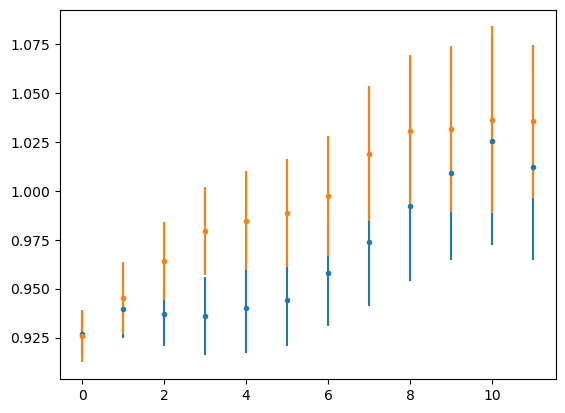

In [37]:
y1S = format(barR['1S'])
yRW = format(barR['RW'])
x   = np.arange(len(y1S))

plt.errorbar(x,gv.mean(y1S),gv.sdev(y1S),fmt='.')
plt.errorbar(x,gv.mean(yRW),gv.sdev(yRW),fmt='.')

# `CUSTOM`

In [19]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object
from b2heavy.ThreePointFunctions.corr3pts   import BINSIZE

In [20]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
io = RatioIO(ens,'R1',mom,PathToDataDir=DATA_DIR)
robj = RatioFitter(
    io,
    jkBin     = BINSIZE[ens],
    smearing  = ['1S','RW'],
    **req
)

In [21]:
robj.format()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 {'1S': array([0.927(12), 0.939(15), 0.937(17), 0.936(20), 0.940(23), 0.944(24),
         0.958(27), 0.974(33), 0.992(38), 1.009(45), 1.025(54), 1.057(65),
         1.273(86)], dtype=object),
  'RW': array([0.926(14), 0.945(18), 0.964(20), 0.979(23), 0.985(25), 0.989(28),
         0.997(31), 1.019(35), 1.031(39), 1.032(43), 1.036(48), 1.067(54),
         1.161(56)], dtype=object)})

In [15]:
format(barR['1S'])

array([0.927(12), 0.939(15), 0.937(17), 0.936(20), 0.940(23), 0.944(24),
       0.958(27), 0.974(33), 0.992(38), 1.009(45), 1.025(53), 1.057(64),
       1.273(85)], dtype=object)

In [16]:
format(barR['RW'])

array([0.926(13), 0.945(18), 0.964(20), 0.979(22), 0.985(25), 0.989(28),
       0.997(31), 1.019(35), 1.031(39), 1.032(42), 1.036(48), 1.067(54),
       1.161(56)], dtype=object)